In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

## SSD
##### Single Shot MultiBox Detector model for object detection

![alt](https://pytorch.org/assets/images/ssd_diagram.png)

# Model Description
### This SSD300 model is based on the SSD: Single Shot MultiBox Detector paper, which describes SSD as “a method for detecting objects in images using a single deep neural network”. The input size is fixed to 300x300.[paper link](http://arxiv.org/abs/1512.02325)

### Additional enhancement: 
* The conv5_x, avgpool, fc and softmax layers were removed from the original classification model.
* All strides in conv4_x are set to 1x1.

The backbone is followed by 5 additional convolutional layers. In addition to the convolutional layers, we attached 6 detection heads:

* The first detection head is attached to the last conv4_x layer.
* The other five detection heads are attached to the corresponding 5 additional layers.

#### The main difference between this model and the one described in the paper is in the backbone. Specifically, the VGG model is obsolete and is replaced by the ResNet-50 model.

#### Reference: https://pytorch.org/hub/nvidia_deeplearningexamples_ssd/

#### The following code will load an SSD model pretrained on COCO dataset from Torch Hub.

In [2]:
import torch 
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


#### importing libraries 

In [3]:
import numpy
import scipy
import skimage 
import matplotlib as mt
from skimage import io,transform

### Loading a set of utility methods for convenient and comprehensive formatting of input and output of the model

In [4]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [5]:
ssd_model.to('cuda')
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [6]:
!pip install torchsummary 

### Using torchsummary to understand the deep layers of the model

In [7]:
from torchsummary import summary

summary(ssd_model, (3, 300, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           9,408
       BatchNorm2d-2         [-1, 64, 150, 150]             128
              ReLU-3         [-1, 64, 150, 150]               0
         MaxPool2d-4           [-1, 64, 75, 75]               0
            Conv2d-5           [-1, 64, 75, 75]           4,096
       BatchNorm2d-6           [-1, 64, 75, 75]             128
              ReLU-7           [-1, 64, 75, 75]               0
            Conv2d-8           [-1, 64, 75, 75]          36,864
       BatchNorm2d-9           [-1, 64, 75, 75]             128
             ReLU-10           [-1, 64, 75, 75]               0
           Conv2d-11          [-1, 256, 75, 75]          16,384
      BatchNorm2d-12          [-1, 256, 75, 75]             512
           Conv2d-13          [-1, 256, 75, 75]          16,384
      BatchNorm2d-14          [-1, 256,

### Collecting the test data 

In [8]:
uris = [
    '/kaggle/input/open-images-2019-object-detection/test/c744be039ce8b59f.jpg',
    '/kaggle/input/open-images-2019-object-detection/test/6ced51a34b3e6bb5.jpg',
    '/kaggle/input/open-images-2019-object-detection/test/5a3215a639ea3308.jpg',
    '/kaggle/input/open-images-2019-object-detection/test/827376834a225c73.jpg',
    '/kaggle/input/open-images-2019-object-detection/test/9a3de6cd6c83f1e0.jpg'
]

#### For convenient and comprehensive formatting of input and output of the model

In [9]:
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, precision == 'fp16')

#### Runingn the SSD network to perform object detection.

In [10]:
with torch.no_grad():
    detections_batch = ssd_model(tensor)

#### By default, raw output from SSD network per input image contains 8732 boxes with localization and class probability distribution. Let’s filter this output to only get reasonable detections (confidence>40%) in a more comprehensive format.

In [11]:
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

#### Downloading annotations as the model was trained on COCO dataset,which we need to access in order to translate class IDs into object names

In [12]:
classes_to_labels = utils.get_coco_object_dictionary()

### Visualising the outcome 

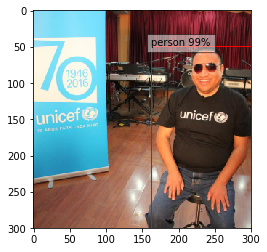

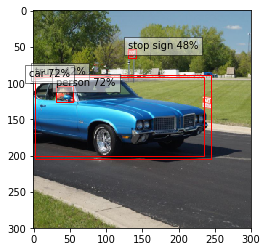

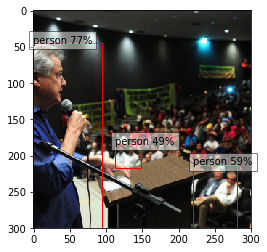

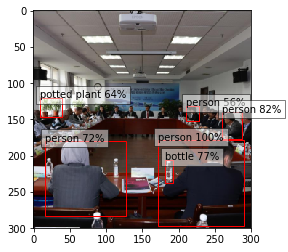

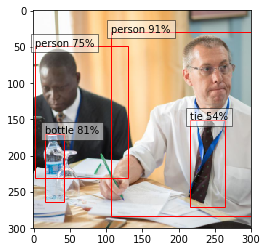

In [13]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()